# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [2]:
# Autograd & Numpy
import autograd
import autograd.numpy as np
import numpy.linalg as alg

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

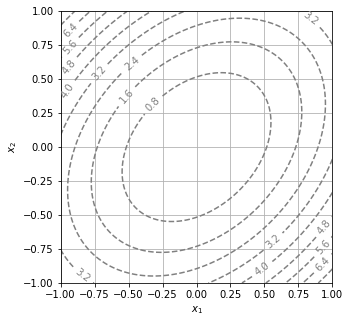

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)





#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [10]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

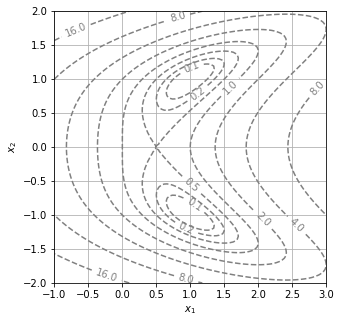

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

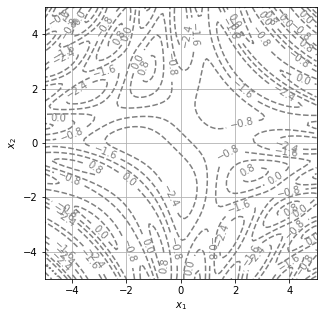

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5 # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [14]:
N = 100 
#Pour N = 100 itérations, on ne peut pas demander une trop grande précision. 
eps = 0.01 
# Une précision de 0.01 suffit pour les tracés de courbes que nous réalisons.

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(F, x0, y0, eps = eps, N = N):
    JF = J(F)
    x, y = x0, y0
    for i in range(N): # On résout le système avec l'inverse de la Jacobienne
        Zk = np.array([x, y])
        ZkPrime = - np.dot(alg.inv(JF(x, y)), F(x, y))
        x, y = x + ZkPrime[0], y + ZkPrime[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return np.array([x, y])
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [16]:
def F1bis(x,y): 
    '''
    On définit la fonction de R^2 dans R^2 qui matérialise la condition 
    f1(x,y) = 0.8 et x = y
    '''
    return np.array([f1(x,y)-0.8,x-y])

In [17]:
print(Newton(F1bis, 0.8, 0.8)) 
x, y = tuple(Newton(F1bis, 0.8, 0.8))
F1bis(x, y) 
# On a bien une solution de f1(x, x) = 0.8 respectant la précision minimale eps 

[0.44725025 0.44725025]


array([0.00013115, 0.        ])

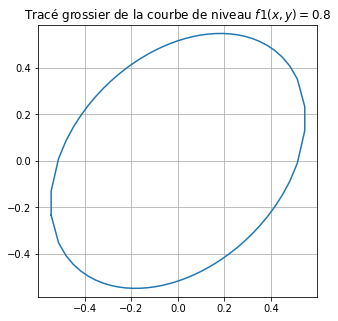

In [18]:
# Ici on utilise la fonction Newton pour redessiner la courbe de niveau 
# f1(x, y) = 0.8 en faisant varier une contrainte sur l'abscisse des 
# solutions que l'on cherche et en utilisant un point de départ choisis à 
# l'aide de la courbe dont on a déjà la forme.

L = []
for absc in np.linspace(-0.545, 0.545, 35): # On trace ici le bas de la courbe
    def f1_var(x, y): 
        # Matérialise f1(x, y) = 0.8 et la condition sur l'abscisse x
        return np.array([f1(x, y) - 0.8, x - absc])
    L.append(Newton(f1_var, 0., -0.5))
for absc in np.linspace(0.545, -0.545, 35): # idem pour le haut de la courbe
    def f1_var(x, y):
        return np.array([f1(x, y) - 0.8, x - absc])
    L.append(Newton(f1_var, 0., 0.5))
L.append(L[0])
    
tab = np.array([list(x) for x in L])
plt.plot(tab[:, 0], tab[:, 1])
plt.title('Tracé grossier de la courbe de niveau $ f1(x, y) = 0.8 $')
plt.grid()
plt.axis('equal')
plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [19]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    c = f(x0, y0)
    points = np.zeros((N, 2))
    points[0] = np.array([x0, y0])
    gradf0 = grad(f)(x0, y0)
    for i in range(1, N):
        def F(x, y): # Materialise f(x, y) = c et d((x0,y0),(x1,y1)) = delta
            return np.array([f(x, y) - c, delta - np.sqrt((x - x0)**2 + (y - y0)**2)]) 
        gradf0 = grad(f)(x0, y0) # gradient de la dernière solution determinée
        a, b = gradf0 / np.sqrt(np.sum(gradf0 ** 2)) # On normalise les vecteurs
        a, b = b, - a 
        x1, y1 = (x0 + delta*a, y0 + delta*b) #Point de départ dans la 
                                              #direction orthogonale au gradient
        points[i] = Newton (F, x1, y1, eps, N) # Calcul de la nouvelle solution
        x0, y0 = points[i] 
    return np.transpose(points)

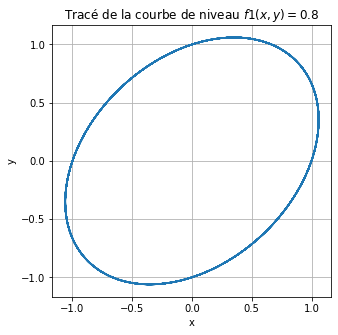

In [20]:
T = level_curve(f1, 1., 0.) 
plt.plot(T[0,:],T[1,:])
plt.title('Tracé de la courbe de niveau $ f1(x, y) = 0.8 $')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()
# On remarque que le tracé semble épais, c'est la conséquence du fait que l'on 
# ne boucle pas notre tracé. Plusieurs "tours" se superposent.

##### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [25]:
# Les commentaires ne concernent que les ajouts pour le bouclage, le reste 
# étant similaire à level_curve(.)

def level_curve_stop(f, x0, y0, delta=0.1, N=1000, eps=eps):
    c = f(x0, y0)
    points = np.zeros((N, 2))
    points[0] = np.array([x0, y0])
    gradf0 = grad(f)(x0, y0)
    x_i, y_i = x0, y0 # On conserve le point de départ
    for i in range(1, N):
        def F(x, y):
            return np.array([
                f(x, y) - c, 
                delta - np.sqrt((x - x0)**2 + (y - y0)**2)
                ])
        gradf0 = grad(f)(x0,y0)
        b, a = gradf0 / np.sqrt(np.sum(gradf0 ** 2))
        a = -a 
        x1, y1 = (x0 + delta*a, y0 + delta*b)
        x1, y1 = Newton (F, x1, y1, eps, N)
        if alg.norm(np.array([x1, y1])-np.array([x_i, y_i])) < delta and i != 1:
            # Si distance du nouveau point au premier < delta, on a bouclé. 
            # Il ne faut pas réaliser cette condition à la première itération  
            points[i] = points[0] # Pour boucler le tracé de courbe
            return np.transpose(points)[:, 0:i+1]
        else : 
            points[i] = x1, y1 # Sinon on peut continuer
            x0, y0 = points[i]
    return np.transpose(points)

# Cette implémentation n'est pas très robuste car on peut imaginer une courbe 
# dont certains points s'approchent sans se toucher ou même une courbe qui 
# s'auto-intersecte. Il faudrait alors jouer avec la variable delta ou ajouter 
# une condition sur l'alignement des gradients des points proches pour ne pas 
# boucler lorsqu'il y a seulement une intersection.

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

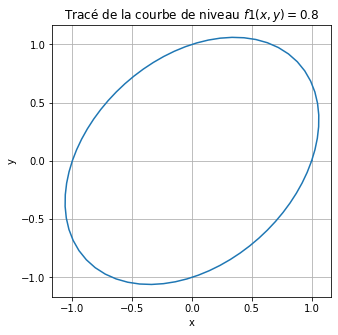

In [70]:
B = level_curve_stop(f1, 1., 0.)
plt.plot(B[0, :], B[1, :])
plt.title('Tracé de la courbe de niveau $ f1(x, y) = 0.8 $')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

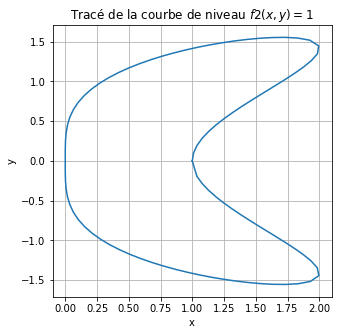

In [71]:
B = level_curve_stop(f2, 1., 0.)
plt.plot(B[0, :], B[1, :])
plt.title('Tracé de la courbe de niveau $ f2(x, y) = 1 $')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

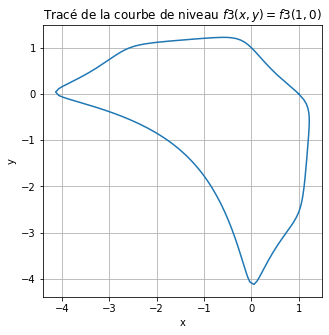

In [72]:
B = level_curve_stop(f3,1.,0.)
plt.plot(B[0,:],B[1,:])
plt.title('Tracé de la courbe de niveau $ f3(x, y) = f3(1,0) $')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [26]:
# fonction qui renvoie les centres de tous les carrés de côté h
# on considère un carré centré en 0 de taille size suffisamment grande 
# (pour que K soit dans le carré)
# que l'on va découper en petits carrés de côté h

def quadrillage(h, size = 1000): # h a vocation à etre bien plus petit que size
    centres_carres = []
    truesize = size - size%h     # on enlève au carré les défauts dûs a la 
                                 # non-divisibilité de size par h
    nb = size // h
    for i in range(int(nb)//2):
            for j in range(int(nb)//2):
                if nb % 2 == 0:        
                    x, y = h*i + h/2, h*j + h/2
                elif nb % 2 == 1:
                    x, y= h*i, h*j
                centres_carres.append([x, y])       
                centres_carres.append([x, -y])
                centres_carres.append([-x, y])
                centres_carres.append([-x, -y])
    return centres_carres

In [27]:
quadrillage(1, 2)

[[0.5, 0.5], [0.5, -0.5], [-0.5, 0.5], [-0.5, -0.5]]

In [28]:
def cercle(x, y):
    return (x**2 + y**2)

In [29]:
def area_squares(f, c, h, size):
    compteur = 0
    for point in quadrillage(h, size):
        x, y = point
        if f(x, y) <= c:
            compteur += 1
    return compteur*(h**2)

In [77]:
area_squares(cercle, 1, 0.05,2) 
# on obtient bien une approximation de pi pour h assez petit et size adapté
# à la fonction (ici size=2 suffit)
# On a les 2 premières décimales en choisissant size=2 et h=0.001 
# (calcul en 11.6s)
# Mais on a encore que les 2 premières décimales en choisissant h=0.0005 
#(calcul en 7min 20.5s) : calcul lent et pas très précis

3.170000000000001

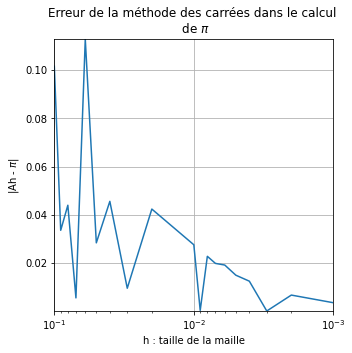

In [78]:
H = [x*10**-3 for x in range(1,10)]+[x*10**-2 for x in range(1,11)]

P = np.array([abs(area_squares(cercle, 1, h, 2) - np.pi) for h in H])

plt.plot(H, P)
plt.xscale("log")
plt.axis([max(H), min(H), min(P), max(P)])
plt.title('Erreur de la méthode des carrées dans le calcul \n de $\pi$')
plt.xlabel('h : taille de la maille')
plt.ylabel('|Ah - $\pi$|')
plt.grid()

plt.show()
# Les calculs deviennent longs en s'approchant de 10^-3

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [30]:
# On peut envisager un calcul qui approche l'aire de manières décroissante 
# comme l'intégrale est maximisée par une fonction étagée supérieure. On 
# choisit ici de vérifier pour chaque carré l'appartenance d'un de ses 4 
# sommets plutôt que l'appartenance du centre. On comptabilisera ainsi 
# chaque carré dont l'un des sommets est dans l'ensemble.

def frame_area_squares(f, c, h, size):
    compteur_min = 0
    compteur_max = 0
    d = h/2
    square_area = h**2
    for point in quadrillage(h, size):
        x, y = point
        haut_droit, bas_droit, bas_gauche, haut_gauche = 0, 0, 0, 0
        if f(x + d, y + d) <= c:   
            # On vérifie l'appartenance de chaque sommet du carré à l'ensemble
            haut_droit = True
        if f(x + d, y - d) <= c:
            bas_droit = True
        if f(x - d, y + d) <= c:
            haut_gauche = True
        if f(x - d, y - d) <= c:
            bas_gauche = True
        if bas_droit or bas_gauche or haut_droit or haut_gauche: 
            # Un sommet appartient
            compteur_max += 1
        if bas_droit and bas_gauche and haut_droit and haut_gauche: 
            # Tous les sommets appartiennent
            compteur_min += 1
    delta = (compteur_max - compteur_min)*square_area
    return compteur_min*(square_area), compteur_max*(square_area), delta

In [31]:
m,M,d = frame_area_squares(cercle, 1, 0.001,2)
print(f'{m} < pi < {M} dans un encadrement de longueur {d}')

# 3.1414199999999997 < pi < 3.148968 dans un encadrement de longueur 0.007548

# Cette méthode est un peu longue et gagnerait en rapidité si l'on conservait
# les informationsd e certains sommets qui appartiennent à 4 carrés différents.

3.1414199999999997 < pi < 3.148968 dans un encadrement de longueur 0.007548


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [32]:
def aireTriangle(p, b, a): # Aire orientée du triangle
    ui = b - p
    uj = a - p
    produit_vect = np.cross(uj, ui)
    return np.sign(produit_vect)*alg.norm(produit_vect)/2
    
def methodeTriangle(border):
    border = np.transpose(border)
    Aire = 0
    N = border.shape[0]
    P = np.array([0, 0])
    for Z in border:
        P = np.add(P, Z)
    P = P/N # on construit P, centre de gravité de la figure.
    for i in range(N - 1):
        Zi = border[i]
        Zi2 = border[i + 1]
        Aire += aireTriangle(P, Zi2, Zi)
    return Aire

In [33]:
def fc(x, y): # Fonction cercle centré en (0,0)
    return x**2 + y**2

In [34]:
border = level_curve_stop(fc, 1., 0., delta=0.01, N=1000)
methodeTriangle(border)

3.141540222561172

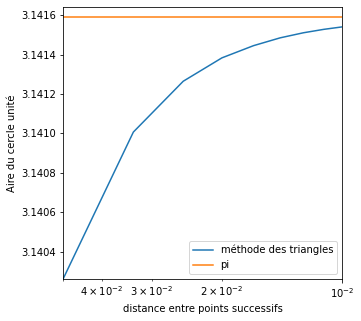

In [36]:
deltas = [1/x for x in range(20,101,10)]
borders = [level_curve_stop(fc, 1., 0., delta, N=1000) for delta in deltas]
B_N = np.array([methodeTriangle(border) for border in borders])

plt.plot(deltas, B_N, label = 'méthode des triangles')
plt.plot([min(deltas), max(deltas)],[np.pi, np.pi], label = 'pi')
plt.xscale('log')
plt.xlabel('distance entre points successifs')
plt.ylabel('Aire du cercle unité')
plt.axis([max(deltas), min(deltas), min(B_N), max(B_N)+0.0001])
plt.legend()
plt.show()


**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [85]:
def methodeTriangle_pointext(border):
    border = np.transpose(border)
    Aire = 0
    N = border.shape[0]
    P = np.array([-2, 0]) # Point exterieur au cercle
    for i in range(N-1):
        Zi = border[i]
        Zi2 = border[i+1]
        Aire += aireTriangle(P, Zi2, Zi)
    return Aire

In [86]:
border_fc = level_curve_stop(fc, 1., 0., delta=0.01, N=10000)
methodeTriangle_pointext(border_fc)

3.141540222561175

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [37]:
def cercle1(x, y):
    return (x-2)**2 + y**2
def cercle2(x, y):
    return (x+2)**2 + y**2
border1 = level_curve_stop(cercle1, 1., 0., delta=0.01, N=1000)
border2 = level_curve_stop(cercle2, -1., 0., delta=0.01, N=1000)
border_tot = np.concatenate((border1, border2),axis = 1)
methodeTriangle(border_tot)

6.28308044512235

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [42]:
def area_triangles(x: list, y: list):
    '''
    Cette fonctionnalité est celle de la fonction méthode_triange codé plus haut,
    les variables demandés par la fonction ne sont simplement pas les mêmes. 
    '''
    assert len(x) == len(y)
    border = np.array([[x[i], y[i]] for i in range(len(x))])
    return methodeTriangle(border)

In [46]:
border_f1 = level_curve_stop(f1, 1., 0.)
border_f2 = level_curve_stop(f2, 1., 0.)
border_f3 = level_curve_stop(f3, 1., 0.)
h = 0.01
S = 4
print(area_squares(f1, f1(1., 0.), h, S), methodeTriangle(border_f1))
print(area_squares(f2, f2(1., 0.), h, S), methodeTriangle(border_f2))
print(area_squares(f3, f3(1., 0.), h, S), methodeTriangle(border_f3))
# On voit un problème dans le calcul de l'aire pour f3
# affichons la courbe de niveau...

3.373 3.326982620013172
3.6794000000000002 3.668477519631287
8.3952 12.88794426957524


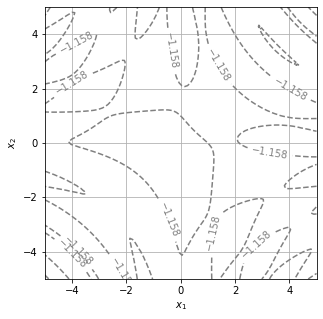

In [47]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels= [f3(1.,0.)] 
)
# L'aire de l'ensemble considéré est complexe à calculer 
# car celui ci n'est pas connexe...